In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score

%matplotlib inline

/Users/Bolito/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('DSI_kickstarterscrape_dataset.csv')
df.head(1)

,project id,name,url,category,subcategory,location,status,goal,pledged,funded percentage,backers,funded date,levels,reward levels,updates,comments,duration
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,"Fri, 19 Aug 2011 19:28:17 -0000",7,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.0


In [3]:
df.shape

(45957, 17)

In [4]:
df.status.value_counts()

successful    22969
failed        18996
live           3929
canceled         59
suspended         4
Name: status, dtype: int64

In [5]:
# Drop status rows labeled as live, canceled, suspended.

df = df[~df['status'].isin(['live', 'canceled', 'suspended'])]

In [6]:
# Replace space in clomun with underscore.
df.columns = df.columns.str.replace(' ', '_')

In [7]:
df.shape

(41965, 17)

In [8]:
# Split up the date to day, time, year, and month.

df['funded_day'] = df.funded_date.apply(lambda x: x.split(',')[0])

In [9]:
df['funded_date'] = pd.to_datetime(df['funded_date'])
df['funded_time'] = [d.time() for d in df['funded_date']]
df['funded_Newdate'] = [d.date() for d in df['funded_date']]

In [10]:
# Convert to String and then to int

df['funded_year'] = df['funded_Newdate'].apply(lambda date: str(date).split('-')[0]).astype(str).astype(int)
df['funded_month'] = df['funded_Newdate'].apply(lambda date: str(date).split('-')[1]).astype(str).astype(int)
df['day_of_month'] = df['funded_Newdate'].apply(lambda date: str(date).split('-')[2]).astype(str).astype(int)

In [11]:
df.head(2)

,project_id,name,url,category,subcategory,location,status,goal,pledged,funded_percentage,...,reward_levels,updates,comments,duration,funded_day,funded_time,funded_Newdate,funded_year,funded_month,day_of_month
0,39409,WHILE THE TREES SLEEP,http://www.kickstarter.com/projects/emiliesaba...,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,...,"$25,$50,$100,$250,$500,$1,000,$2,500",10,2,30.00,Fri,19:28:17,2011-08-19,2011,8,19
1,126581,Educational Online Trading Card Game,http://www.kickstarter.com/projects/972789543/...,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,...,"$1,$5,$10,$25,$50",6,0,47.18,Mon,03:59:00,2010-08-02,2010,8,2


In [12]:
df.shape

(41965, 23)

In [13]:
# Drop irrelevant columns.

df.drop(['name', 'url', 'reward_levels' ], axis = 1, inplace = True)
df.head()

,project_id,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,levels,updates,comments,duration,funded_day,funded_time,funded_Newdate,funded_year,funded_month,day_of_month
0,39409,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,2011-08-19 19:28:17,7,10,2,30.00,Fri,19:28:17,2011-08-19,2011,8,19
1,126581,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,2010-08-02 03:59:00,5,6,0,47.18,Mon,03:59:00,2010-08-02,2010,8,2
3,237090,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,2012-04-08 02:14:00,13,4,0,32.22,Sun,02:14:00,2012-04-08,2012,4,8
4,246101,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,2011-06-01 15:25:39,6,2,0,30.00,Wed,15:25:39,2011-06-01,2011,6,1
5,316217,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,1.023331,39,2011-06-22 13:33:00,7,8,0,21.43,Wed,13:33:00,2011-06-22,2011,6,22


In [14]:
# Drop NaN values

df.dropna(inplace = True)

In [15]:
# Drop a particular row because it location is unavailable.

df.drop([7762], inplace = True)

In [16]:
df.head()

,project_id,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,levels,updates,comments,duration,funded_day,funded_time,funded_Newdate,funded_year,funded_month,day_of_month
0,39409,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,2011-08-19 19:28:17,7,10,2,30.00,Fri,19:28:17,2011-08-19,2011,8,19
1,126581,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,2010-08-02 03:59:00,5,6,0,47.18,Mon,03:59:00,2010-08-02,2010,8,2
3,237090,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,2012-04-08 02:14:00,13,4,0,32.22,Sun,02:14:00,2012-04-08,2012,4,8
4,246101,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,2011-06-01 15:25:39,6,2,0,30.00,Wed,15:25:39,2011-06-01,2011,6,1
5,316217,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,1.023331,39,2011-06-22 13:33:00,7,8,0,21.43,Wed,13:33:00,2011-06-22,2011,6,22


In [17]:
# Split up City and States because some of them contain State and Country.

df['city'] = df.location.apply(lambda x: x.split(',')[0])
df['state'] = df.location.apply(lambda x: x.split(',')[1])

In [18]:
df.head()

,project_id,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,...,comments,duration,funded_day,funded_time,funded_Newdate,funded_year,funded_month,day_of_month,city,state
0,39409,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,2011-08-19 19:28:17,...,2,30.00,Fri,19:28:17,2011-08-19,2011,8,19,Columbia,MO
1,126581,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,2010-08-02 03:59:00,...,0,47.18,Mon,03:59:00,2010-08-02,2010,8,2,Maplewood,NJ
3,237090,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,2012-04-08 02:14:00,...,0,32.22,Sun,02:14:00,2012-04-08,2012,4,8,Los Angeles,CA
4,246101,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,2011-06-01 15:25:39,...,0,30.00,Wed,15:25:39,2011-06-01,2011,6,1,Novi,MI
5,316217,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,1.023331,39,2011-06-22 13:33:00,...,0,21.43,Wed,13:33:00,2011-06-22,2011,6,22,Portland,OR


In [19]:
# Split up States and create a new column for that.

def split_it(state):
     return re.findall('([A-Z]{2,})', state)

df['STATE'] = df['state'].apply(split_it)

In [20]:
def split_it(state):
     return re.findall('[A-Z][a-z]+', state)

df['Country'] = df['state'].apply(split_it)

In [21]:
# Remove [] in STATE Column and Country

df['STATE'] = df['STATE'].str[0]
df['Country'] = df['Country'].str[0]

In [22]:
# Fill in NaN values for Country (United State)
df.Country.fillna(value = 'United States', inplace = True)

In [23]:
# Assigning country names using country listed in state column
df.loc[df.Country == 'United', 'Country'] = df.loc[df.Country == 'United', 'state']
df.loc[df.Country == 'South', 'Country'] = df.loc[df.Country == 'South', 'state']
df.loc[df.Country == 'Saint', 'Country'] = df.loc[df.Country == 'Saint', 'state']
df.loc[df.Country == 'Saudi', 'Country'] = df.loc[df.Country == 'Saudi', 'state']
df.loc[df.Country == 'Mt', 'Country'] = df.loc[df.Country == 'Mt', 'state']
df.loc[df.Country == 'Viet', 'Country'] = df.loc[df.Country == 'Viet', 'state']
df.loc[df.Country == 'Kyoto', 'Country'] = df.loc[df.Country == 'Kyoto', 'state']
df.loc[df.Country == 'Sri', 'Country'] = df.loc[df.Country == 'Sri', 'state']
df.loc[df.Country == 'Sierra', 'Country'] = df.loc[df.Country == 'Sierra', 'state']
df.loc[df.Country == 'Isle', 'Country'] = df.loc[df.Country == 'Isle', 'state']
df.loc[df.Country == 'Central', 'Country'] = df.loc[df.Country == 'Central', 'state']
df.loc[df.Country == 'Argent', 'Country'] = df.loc[df.Country == 'Argent', 'state']
df.loc[df.Country == 'El', 'Country'] = df.loc[df.Country == 'El', 'state']
df.loc[df.Country == 'Costa', 'Country'] = df.loc[df.Country == 'Costa', 'state']
df.loc[df.Country == 'Svalbard', 'Country'] = df.loc[df.Country == 'Svalbard', 'state']
df.loc[df.Country == 'Virgin', 'Country'] = df.loc[df.Country == 'Virgin', 'state']
df.loc[df.Country == 'Czech', 'Country'] = df.loc[df.Country == 'Czech', 'state']
df.loc[df.Country == 'New', 'Country'] = df.loc[df.Country == 'New', 'state']
df.loc[df.Country == 'Hong', 'Country'] = df.loc[df.Country == 'Hong', 'state']
df.loc[df.Country == 'Argentinaina', 'Country'] = df.loc[df.Country == 'Argentinaina', 'state']
df.loc[df.Country == 'Puerto', 'Country'] = df.loc[df.Country == 'Puerto', 'state']
df.loc[df.Country == 'Papua', 'Country'] = df.loc[df.Country == 'Papua', 'state']
df.loc[df.Country == 'Dominican', 'Country'] = df.loc[df.Country == 'Dominican', 'state']
df.loc[df.Country == 'Falkland', 'Country'] = df.loc[df.Country == 'Falkland', 'state']
df.loc[df.Country == 'Palestinian', 'Country'] = df.loc[df.Country == 'Palestinian', 'state']
df.loc[df.Country == 'Palestinian', 'Country'] = df.loc[df.Country == 'Palestinian', 'state']
df.loc[df.Country == 'Libyan', 'Country'] = df.loc[df.Country == 'Libyan', 'state']
df.loc[df.Country == 'Syrian', 'Country'] = df.loc[df.Country == 'Syrian', 'state']

In [24]:
# Rename Countries
df.Country = df.Country.str.replace('Mt', 'United States ')
df.Country = df.Country.str.replace('Kyoto', 'Japan')
df.Country = df.Country.str.replace('Argent', 'Argentina')
df.Country = df.Country.str.replace('Argentinaina', 'Argentina')
df.Country = df.Country.str.replace('Dominican Re', 'Dominican Republic')
df.Country = df.Country.str.replace('Congo', 'DR Congo')


In [25]:
# Rename City
df.city = df.city.str.replace('Ciudad Aut���_noma De Buenos Aires', 'Buenos Aires')
df.city = df.city.str.replace('Lim���_n', 'Lima')
df.city = df.city.str.replace('Panam��΍', 'San Jose')
df.city = df.city.str.replace('H�Ċܢibiny, ', 'Hradec Králové')

In [26]:
# Replace the space infront of the changed countries.
#df.Country = df.Country.str[].replace(' ', '')

In [27]:
df.head(5)

,project_id,category,subcategory,location,status,goal,pledged,funded_percentage,backers,funded_date,...,funded_day,funded_time,funded_Newdate,funded_year,funded_month,day_of_month,city,state,STATE,Country
0,39409,Film & Video,Short Film,"Columbia, MO",successful,10500.0,11545.0,1.099524,66,2011-08-19 19:28:17,...,Fri,19:28:17,2011-08-19,2011,8,19,Columbia,MO,MO,United States
1,126581,Games,Board & Card Games,"Maplewood, NJ",failed,4000.0,20.0,0.005000,2,2010-08-02 03:59:00,...,Mon,03:59:00,2010-08-02,2010,8,2,Maplewood,NJ,NJ,United States
3,237090,Film & Video,Documentary,"Los Angeles, CA",successful,6000.0,6535.0,1.089167,100,2012-04-08 02:14:00,...,Sun,02:14:00,2012-04-08,2012,4,8,Los Angeles,CA,CA,United States
4,246101,Fashion,Fashion,"Novi, MI",failed,3500.0,0.0,0.000000,0,2011-06-01 15:25:39,...,Wed,15:25:39,2011-06-01,2011,6,1,Novi,MI,MI,United States
5,316217,Film & Video,Short Film,"Portland, OR",successful,3500.0,3582.0,1.023331,39,2011-06-22 13:33:00,...,Wed,13:33:00,2011-06-22,2011,6,22,Portland,OR,OR,United States


In [28]:
df.drop(['state', 'location', 'funded_date', 'funded_time', 'funded_year', 'funded_Newdate'], axis =1, inplace = True)

In [29]:
df.head()

,project_id,category,subcategory,status,goal,pledged,funded_percentage,backers,levels,updates,comments,duration,funded_day,funded_month,day_of_month,city,STATE,Country
0,39409,Film & Video,Short Film,successful,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,8,19,Columbia,MO,United States
1,126581,Games,Board & Card Games,failed,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,8,2,Maplewood,NJ,United States
3,237090,Film & Video,Documentary,successful,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,4,8,Los Angeles,CA,United States
4,246101,Fashion,Fashion,failed,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,6,1,Novi,MI,United States
5,316217,Film & Video,Short Film,successful,3500.0,3582.0,1.023331,39,7,8,0,21.43,Wed,6,22,Portland,OR,United States


In [30]:
#bins = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
#group_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
#categories = pd.cut(df.funded_month, bins, labels=group_names)
#df.funded_month = categories

In [31]:
# df.to_csv('cleaned_kickstarter.csv', index = False)

In [32]:
df['status'] = df.status.str.contains('successful').astype(int)

In [33]:
df.rename(columns={'STATE':'state'}, inplace =True)

In [34]:
df.head(2)

,project_id,category,subcategory,status,goal,pledged,funded_percentage,backers,levels,updates,comments,duration,funded_day,funded_month,day_of_month,city,state,Country
0,39409,Film & Video,Short Film,1,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,8,19,Columbia,MO,United States
1,126581,Games,Board & Card Games,0,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,8,2,Maplewood,NJ,United States


In [35]:
def classifier(row):
    if row.Country in ['United States', 'Canada', 'Guatemala', 'Mexico', 'Puerto Rico', 'Nicaragua', 'El Salvador', 'Panama', 'Bolivia', 'Middleburg', 'Guam']:
        return 'America'
    elif row.Country in ['Nigeria', 'Ghana', 'South Africa', 'Kenya', 'Ethiopia', 'DR Congo', 'Morocco', 'Tanzania', 'Zambia', 'Liberia', 'Rwanda', 'Mali', 'Cameroon', 'Namibia', 'Zimbabwe', 'Tunisia', 'Sierra Leone', 'Central African Republic', 'Uganda', 'Sudan', 'Senegal', 'Malawi', 'Mozambique', 'Libyan Arab Jamahiriya', 'Guinea', 'Swaziland']:
        return 'Africa'
    elif row.Country in ['United Kingdom', 'Norway', 'Germany', 'Sweden', 'Bosnia', 'Iceland', 'Hungary', 'Italy', 'Netherlands','France', 'United Kingdom', 'Austria',
       'Turkey','Finland', 'Czech Republic','Armenia', 'Portugal','Denmark','Switzerland', 'Svalbard and Jan Mayen', 'Russia', 'Ukraine', 'Bulgaria','Spain','Poland', 'Georgia','Ireland','Greece','Serbia','Slovenia','Belgium','Greenland','Romania','Lithuania', 'Micronesia','Estonia','Cyprus', 'Macedonia','Kyrgyzstan',]:
        return 'Europe'
    elif row.Country in ['Jamaica', 'Haiti','Bahamas','Dominican Republic','Saint Lucia', 'Dominican Republicpublic', 'Trinidad']:
        return 'Carribean'
    elif row.Country in ['China', 'Taiwan', 'Hong Kong', 'Nepal', 'Indonesia', 'Singapore', 'India', 'Japan', 'Lebanon', 'Kazakhstan', 'South Korea', 'Philippines', 'Cambodia', 'Thailand','Malaysia','Bhutan','Sri Lanka','Bermuda','Viet Nam','Bangladesh', 'Laos','Guam']:
        return 'Asia'
    elif row.Country in ['Israel','Qatar', 'Afghanistan','Kazakhstan','United Arab Emirates','Palestinian Territories','Syrian Arab Republic','Saudi Arabia', 'Iraq','Iran','Tajikistan',]:
        return 'Arab'
    else:
        return "Oceania"   
df["continent"] = df.apply(classifier, axis=1)

In [36]:
df.head()

,project_id,category,subcategory,status,goal,pledged,funded_percentage,backers,levels,updates,comments,duration,funded_day,funded_month,day_of_month,city,state,Country,continent
0,39409,Film & Video,Short Film,1,10500.0,11545.0,1.099524,66,7,10,2,30.00,Fri,8,19,Columbia,MO,United States,America
1,126581,Games,Board & Card Games,0,4000.0,20.0,0.005000,2,5,6,0,47.18,Mon,8,2,Maplewood,NJ,United States,America
3,237090,Film & Video,Documentary,1,6000.0,6535.0,1.089167,100,13,4,0,32.22,Sun,4,8,Los Angeles,CA,United States,America
4,246101,Fashion,Fashion,0,3500.0,0.0,0.000000,0,6,2,0,30.00,Wed,6,1,Novi,MI,United States,America
5,316217,Film & Video,Short Film,1,3500.0,3582.0,1.023331,39,7,8,0,21.43,Wed,6,22,Portland,OR,United States,America


In [37]:
df.rename(columns = {'Country': 'country'}, inplace = True)

In [38]:
# Convert features (columns) values to number to prepare for Machine learning Modeling process.

from sklearn import preprocessing
def encode_features(df):
    features = ['category', 'status', 'subcategory', 'state', 'pledged', 'backers', 'funded_month', 'city', 'country', 'continent']
    df_combined = pd.concat([df])
    
    for feature in features:
        le = preprocessing.LabelEncoder()
        le = le.fit(df_combined[feature])
        df[feature] = le.transform(df[feature])
    return df
    
data = encode_features(df)
data.head()

/Users/Bolito/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/Users/Bolito/anaconda2/lib/python2.7/site-packages/numpy/lib/arraysetops.py:275: FutureWarning: numpy equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  return aux[:-1][aux[1:] == aux[:-1]]


,project_id,category,subcategory,status,goal,pledged,funded_percentage,backers,levels,updates,comments,duration,funded_day,funded_month,day_of_month,city,state,country,continent
0,39409,5,45,1,10500.0,7516,1.099524,66,7,10,2,30.00,Fri,7,19,707,25,139,1
1,126581,8,3,0,4000.0,19,0.005000,2,5,6,0,47.18,Mon,7,2,2026,32,139,1
3,237090,5,15,1,6000.0,5353,1.089167,100,13,4,0,32.22,Sun,3,8,1930,5,139,1
4,246101,4,17,0,3500.0,0,0.000000,0,6,2,0,30.00,Wed,5,1,2449,23,139,1
5,316217,5,45,1,3500.0,3286,1.023331,39,7,8,0,21.43,Wed,5,22,2734,38,139,1


In [39]:
df['avg_per_level'] = df.goal / df.levels

In [40]:
df.continent.value_counts()

1    38887
6      679
5      539
3      291
0      136
2       68
4       42
Name: continent, dtype: int64

In [41]:
X = df.drop(['status', 'funded_day', 'day_of_month', 'project_id', 'pledged', 'funded_percentage', 'backers', 'funded_month', 'updates', 'comments'], axis=1)
y = df['status']

In [42]:
from sklearn.preprocessing import Imputer
X = Imputer().fit_transform(X)

# Using kNN Model

In [51]:
k_range = range(80,200)
k_scores = []
for k in k_range:
    print k
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = 'accuracy')
    k_scores.append(scores.mean())
print k_scores

80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
[0.63163722100547381, 0.63193266007143456, 0.63200626706500196, 0.63212931672367512, 0.6321785232778292, 0.63185857476401819, 0.6322031356451504, 0.63215391091348772, 0.63232606419194581, 0.63311348999448791, 0.63227686973825281, 0.63279365046825609, 0.63264605504545146, 0.6327689049154136, 0.63163718462363971, 0.63185856262482143, 0.63163722701398883, 0.63171087031489859, 0.63168642749705473, 0.63178471949646509, 0.63121879880655807, 0.63146480731085375, 0.63070204833962573, 0.63109567042635639, 0.63082504957261776, 0.630923480828637

In [44]:
scores.mean()

0.63131681839363407

In [45]:
scores.max()

0.63739237392373926

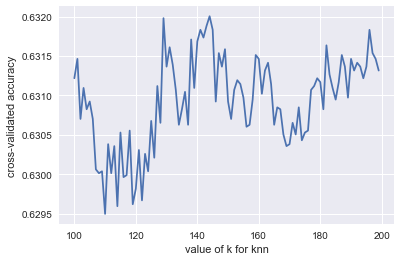

In [46]:
plt.plot(k_range, k_scores)
plt.xlabel('value of k for knn')
plt.ylabel('cross-validated accuracy')

In [50]:
MSE = [1 - x for x in k_scores]
optimal_k = k_range[MSE.index(min(MSE))]
print "The optimal number of neighbors is %d" % optimal_k

The optimal number of neighbors is 144


In [ ]:
project_id = X_test.project_id
predictions = predictions


output = pd.DataFrame({ 'project_id' : project_id, 'predictions': predictions })
# output.to_csv('Kickstarter-predictions.csv', index = False)
output.head()